# Preprocesamiento de una sesión para un sujeto de la base de datos de Shu_Dataset

La base de datos se compone por 25 participantes, 12 mujeres y 13 hombres. 
El preprocesamiento se compone de los siguientes pasos: 
* Filtrado
* Detección y etiquetado de malos canales por z-score
* Detección y etiquetado de malas epocas por z-score (No se eliminan)
* Detección, etiquetado y remoción de componentes ica eog y emg.
* Reconstrucción de datos.
* Detección , etiquetado de malas epocas por z-score.
* Eliminación de malas epocas.
* Guardado

### Importamos las librerías

In [3]:
#  Importamos las librerías que vamos a utilizar
from shu_dataset import ShuDataset
import json
import pandas as pd
from fairness.functions import * 

### Leemos las caracteristicas de la base de datos

In [4]:
#%% Leemos los datos y adaptamos la base de datos para obtener las epocas acondicionadas
path_root = "/home/bruno/Academico/Doctorado/Neuro_Fairness/Shu_Dataset/"
dataset_field="A_Dataset/"
info_channels="task-motorimagery_channels.tsv"
info_eeg_setup="task-motorimagery_eeg.json"
info_electrodes_position="task-motorimagery_electrodes.tsv"
info_channels=pd.read_csv(dataset_field+info_channels,sep='\t')
info_participants = "participants.tsv"
info_eeg_setup=open(dataset_field+info_eeg_setup,)
info_eeg_setup=json.load(info_eeg_setup)

# Elegimos al participante

In [5]:
#%% Cargamos los datos para un sujeto y sesión
participant="sub-001"
session="ses-01"

database_path = path_root + dataset_field + participant + "/"
data_path=participant+"_"+session+"_task_motorimagery_eeg.mat"

# Llamamos al constructor de la clase

In [6]:
#%% Acondicionamos los datos
register=ShuDataset(path=database_path+data_path)
#% Cargamos la descripcion de los participantes
register.load_participants_description(participant=participant,path=dataset_field+info_participants)
register.load_info_channels(nchans=info_eeg_setup['EEGChannelCount'], channels_names=list(info_channels['name']))
register.load_sampling_rate(fs=info_eeg_setup['SamplingFrequency'])

Se cargó el archivo


# Graficamos los datos y la espectro de potencias de cada canal

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


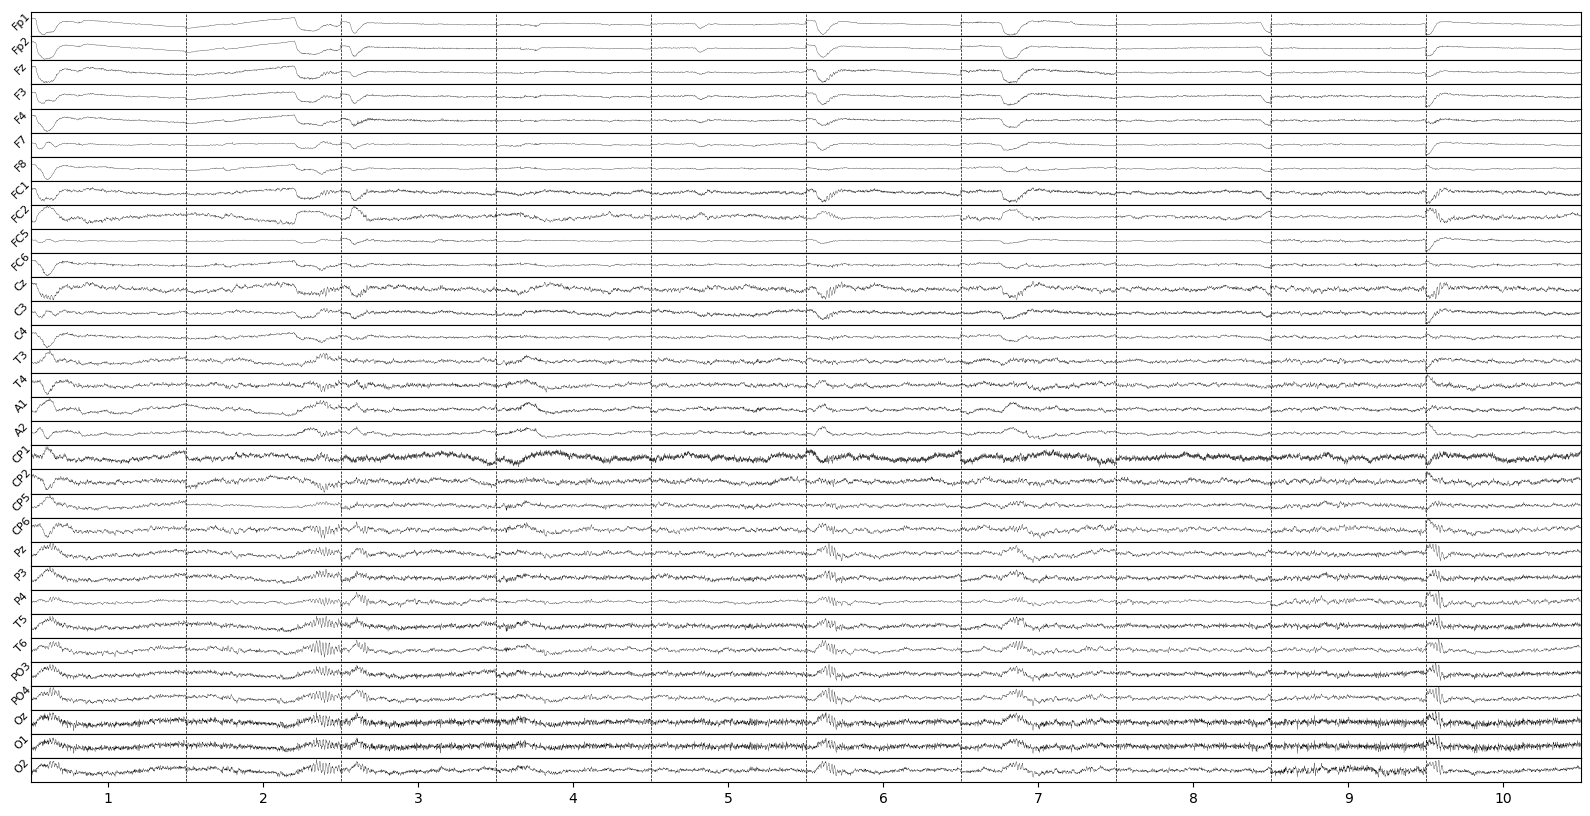

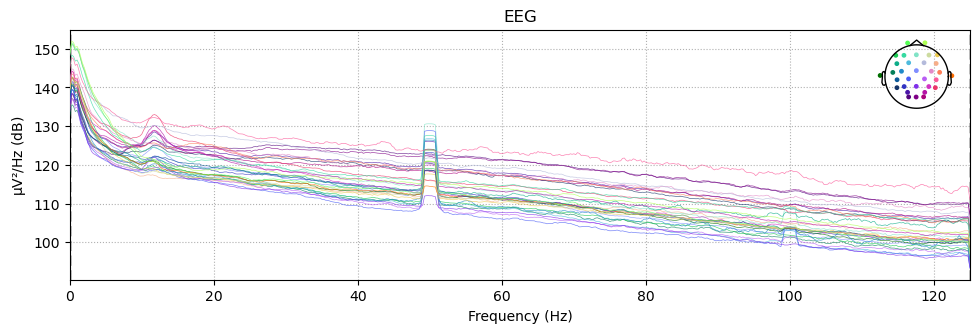

In [8]:
#Graficamos los datos 
register.plot_eeg_data()
#Graficamos la densidad espectral
register.plot_eeg_data_psd()

# 1.Filtrado

Los filtros utilizados son :
* Pasabajos Butterwort de orden 5 y fc 43 Hz
* Pasaaltos Butterworth de orden 5 y fc 1 Hz
* Filtro Notch a 50 Hz y factor de calidad de 20.

In [9]:
# FILTRADO
# Filtro Pasa-Banda
l_freq=1. 
h_freq=43.
order=5
# Filtro Notch
f_notch=50.
q_factor=20.
#Filtramos 
register.filter(freq=l_freq, filter_type="highpass", order=order)
register.filter(freq=h_freq, filter_type="lowpass", order=order)
register.filter_notch(f=f_notch,qf=q_factor)

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


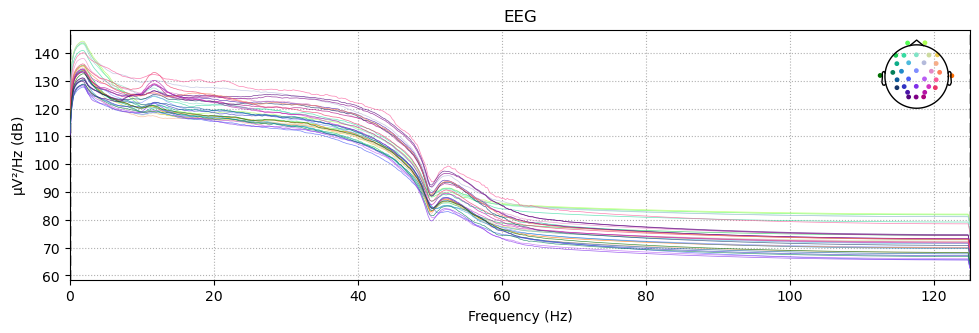

In [10]:
#Graficamos la Densidad espectral
register.plot_eeg_data_psd()

# 2. Encontramos los canales "malos". 

Para encontrarlos se implementa un analisis iterativo del z-score del desvío estandar de cada canal. De esta forma podemos hallar aquellos canales afectados por la impedancia de los electrodos. 

Los canales se etiquetan, pero no se eliminan. 

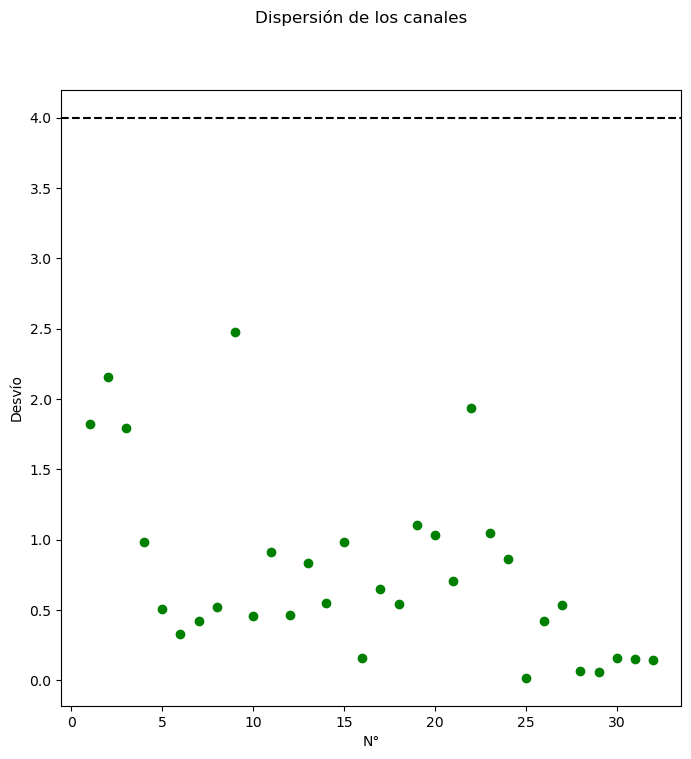

No hay canales malos


In [11]:
#Identificamos los canales malos
bad_ch = register.find_bad_channels()


# 3.Z-scoreamos los canales.

Realizamos este procedimiento para re-escalar todos los canales a varianza unidad y media cero. De esta forma podemos analizar los canales detectados como outlaiers.

In [12]:
#Z-scoreamos los datos
register.data_z_score()

# 4. Detección de epocas malas

Para la detección de las epocas malas, implementamos un análisis iterativo del z-score de la desviación media de la estimación de la media del canal a lo largo de las epocas.

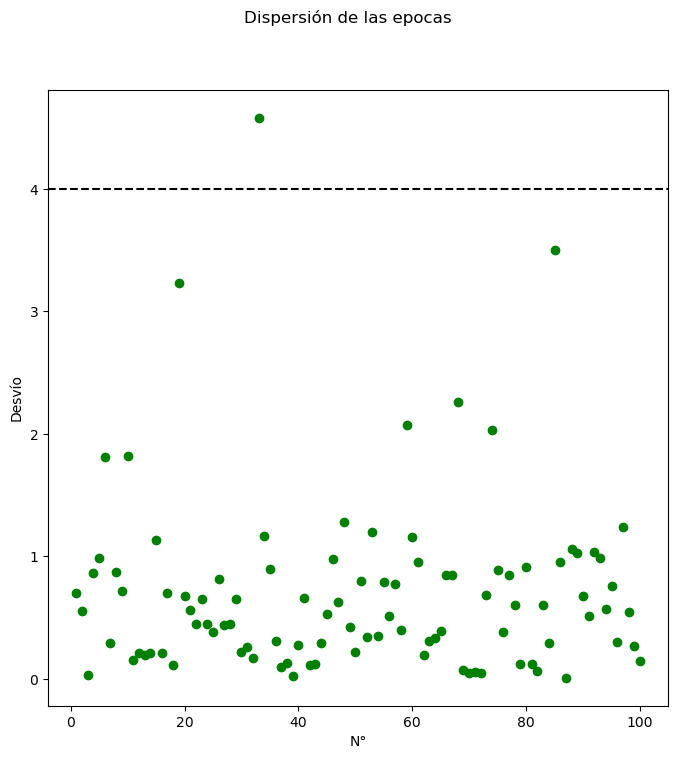

Epocas Malas:
[32]


In [13]:
#Encontramos epocas malas
bad_epochs_0 = register.find_bad_epochs()

# 5. Computo de las IC y detección de las ICs artefactos de EOG y EMG

In [14]:

# METODO DE ANALISIS DE COMPONENTES INDEPENDIENTES
ica_method='FastICA-mne'

# Computamos ICA
register.compute_ica(method=ica_method)

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA to data using 32 channels (please be patient, this may take a while)


/home/bruno/Academico/Doctorado/Neuro_Fairness/Shu_Dataset/fairness/functions_mne.py:139: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ICA_mne.fit(X_mne,picks=['eeg'])


Selecting by number: 32 components
Fitting ICA took 10.5s.


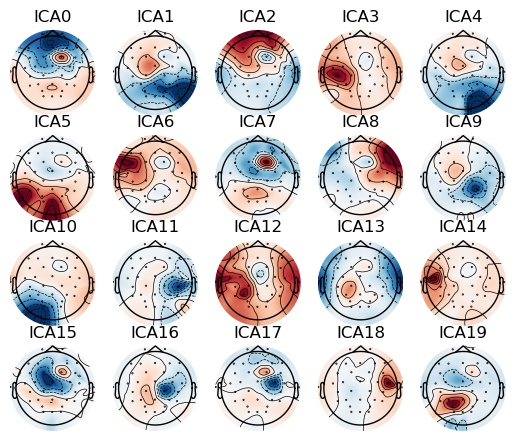

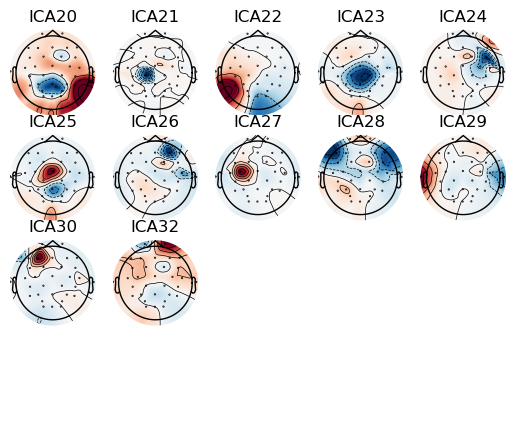

In [15]:
register.plot_ica_components(savefig=False)

In [16]:
#Ploteamos las componentes de ICA
register.plot_ica_sources(savefig=False)

## Hallamos el artefacto EOG.

Para esto lo que se realiza es un análisis iterativo del z-score del coeficiente de correlación de Pearson de las ICs con una señal similar a la de EOG. En este caso, utilizamos los electrodos frontales que capturan parte de la señal de EOG, y dado que el task es de imageneria motora (la señal neuronal se encuentra presente en la corteza motora), no se ven a fectadas las fuentes neuronales:
* Fp1, Fp2, (Fp2-Fp1) y Fz.

In [17]:
#Encontramos las componentes que corresponden a EOG
idx_eog = register.find_eog_ica()

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using EOG channels: EOG000, EOG001, EOG002, EOG003


## Hallamos el artefacto EMG.

Para esto lo que se realiza es un análisis iterativo del z-score de un coeficiente, que involucra a:
* Las pendientes en escala logaritmica de la espectro de potencias de la ICs, el cual se calcula desde los 7 Hz a 45Hz, se explica que la pendientes de las componentes de ICs muscular deben ser negativas y las de origen neural positivas.
* Analizan la periferia, principalmente analizan los pesos de la matriz de mezcla tomando en cuenta la distancia de los electrodos al vertice de la cabeza. Las fuentes neurales deben encontrarse cercanas a la cabeza, mientras que las que no se hayan lejos.
* Suavizado espacial, lo que hace este valor es encontrar aquellas componentes que sean mezcla de fuentes. Entonces computan la diferencia relativa entre pares de electrodos pesados por la distancia entre ellos, esperandose que ICs de mezclas presenten largas variaciones.

In [18]:
idx_emg, _ = register.find_emg_ica()

Creating RawArray with float64 data, n_channels=32, n_times=100000
    Range : 0 ... 99999 =      0.000 ...   399.996 secs
Ready.
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


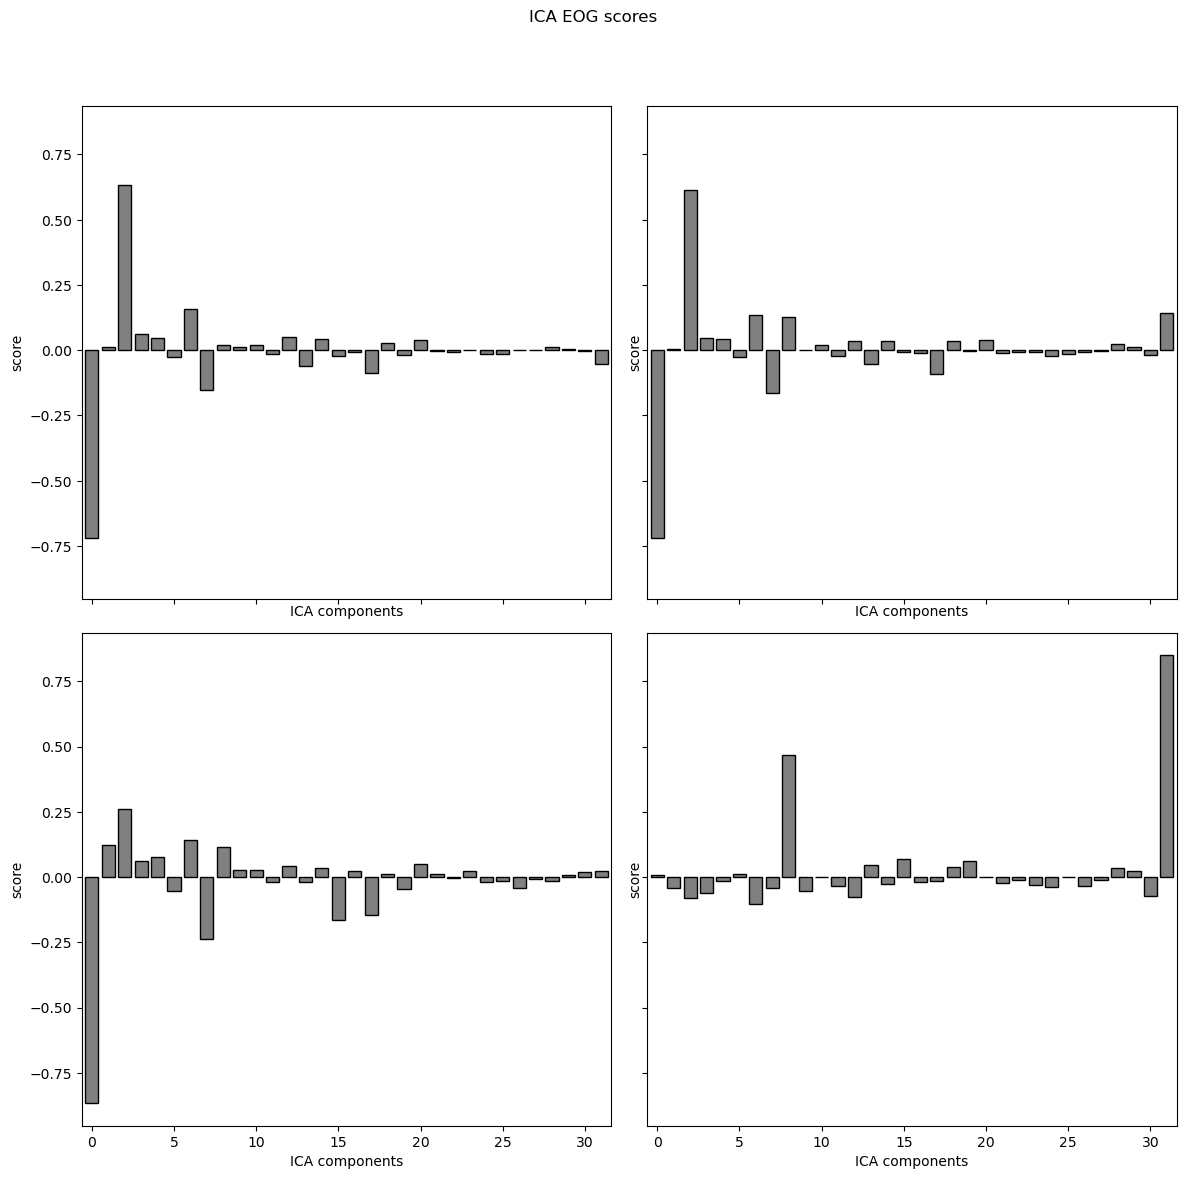

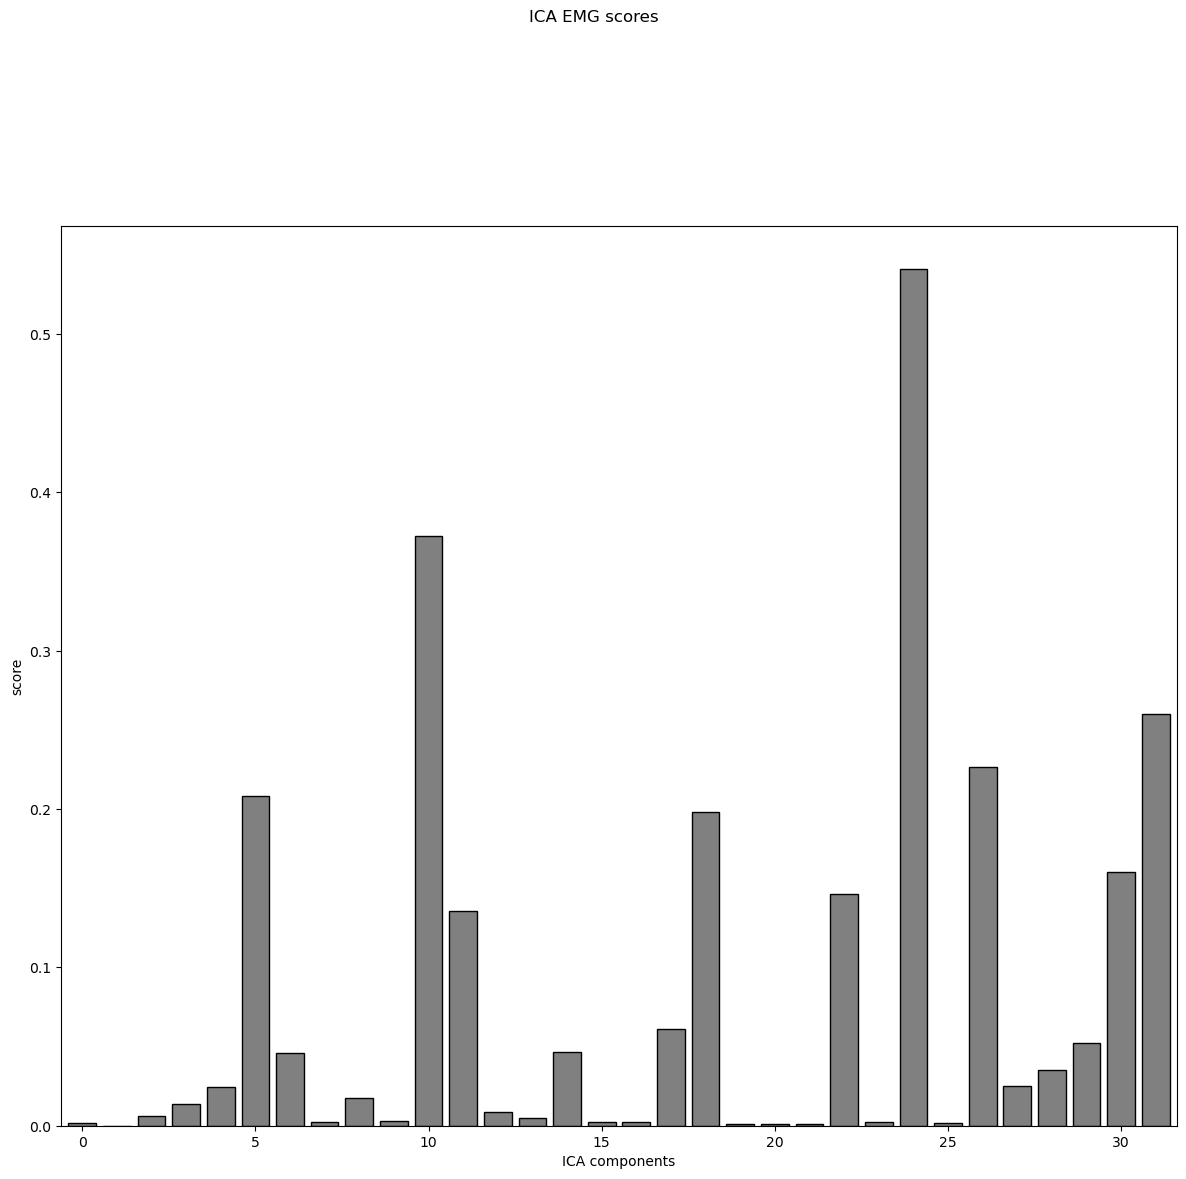

In [20]:
#Graficamos los scores
register.plot_ica_scores(savefig=False)

# 6. Reconstruimos las caracteristas luego de haber eliminado las ICs

In [21]:
#Reconstruimos los datos
register.reconstruct_data()

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 8 ICA components
    Projecting back using 32 PCA components


Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


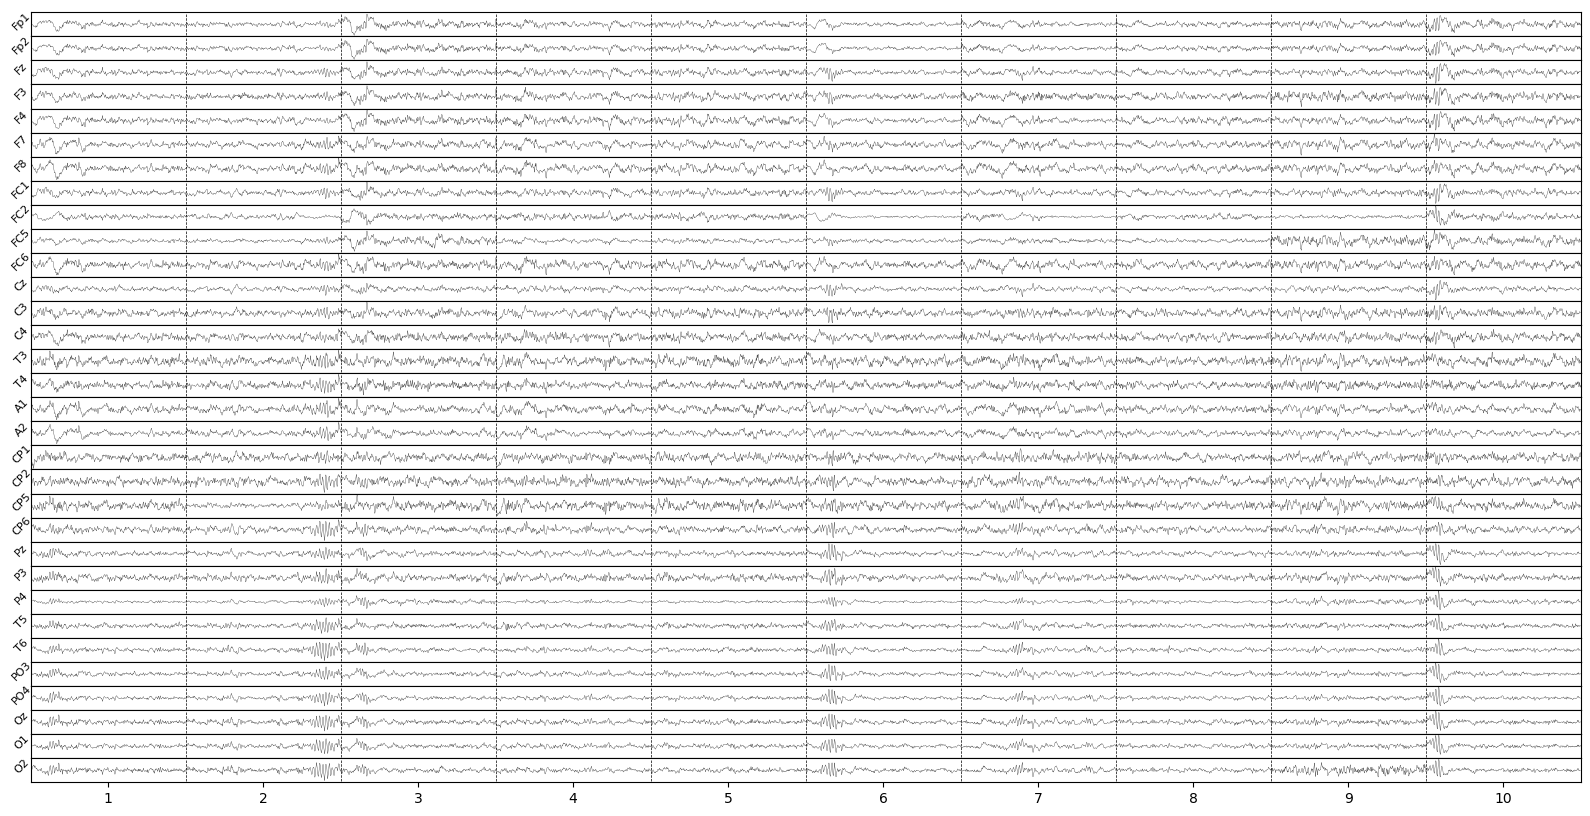

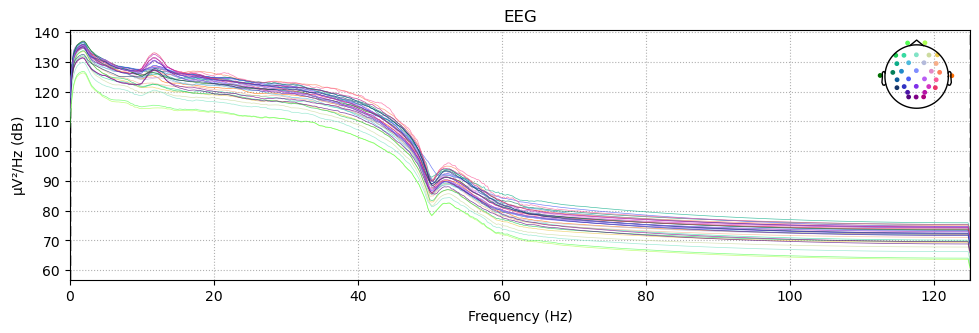

In [25]:
#Datos reconstruidos
register.plot_eeg_data()
register.plot_eeg_data_psd()

# 7. Analizamos si existen epocas "malas"

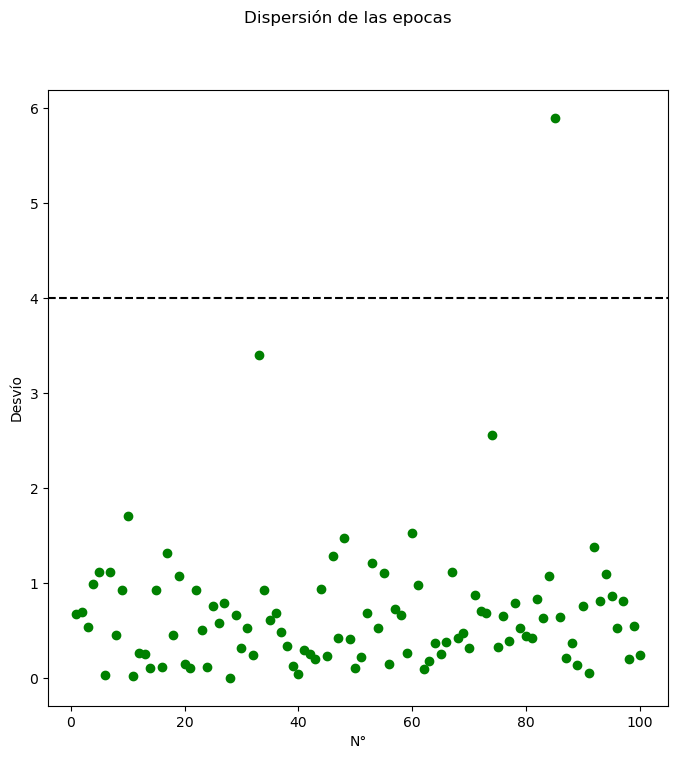

Epocas Malas:
[32, 84]


In [26]:
bad_epochs_1 = register.find_bad_epochs()

# 8. Removemos las epocas "malas" 

In [27]:
register.remove_bad_epochs()

# 7. Guardamos los datos preprocesados

Ejecutando las lineas: 

save_register=True

if save_register:

    save_path_root = path_root + "B_Dataset_Preprocessing/" + participant +"/"+participant+"_"

    save_path = save_path_root + session + "_task_motorimagery_eeg_preprocessing.mat"
    
    register.save_data(save_path=save_path)
            